In [1]:
import os
import scipy.io
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from complexPyTorch.complexLayers import ComplexLinear
from complexPyTorch.complexFunctions import complex_relu
import matplotlib.pyplot as plt

In [23]:
# Define the Dataset
class RASPNetDataset(Dataset):
    def __init__(self, data_dir, csv_file, split, limit):
        """
        Args:
            data_dir (string): Directory with all the data.
            csv_file (string): Path to the csv file with labels.
            split (string): 'train' or 'test'.
            limit (int): Number of samples to load.
        """
        self.data_dir = data_dir
        self.split = split
        self.limit = limit

        # Load labels
        labels_df = pd.read_csv(csv_file)
        self.labels = torch.from_numpy(labels_df[['R_idx', 'Az_idx', 'El_idx']].values[:limit].astype(np.float32)) # x, y, z
        self.labels = self.labels

        # Initialize lists to hold features
        features_list = []

        # Paths to real and imaginary folders
        real_dir = os.path.join(data_dir, split)
        imag_dir = os.path.join(data_dir, split)

        # Load all real and imag data into memory
        for i in range(1, limit + 1):
            # Construct file names
            real_file = f'real{i}.mat'
            imag_file = f'imag{i}.mat'

            real_path = os.path.join(real_dir, real_file)
            imag_path = os.path.join(imag_dir, imag_file)

            # Load .mat files
            try:
                real_data = scipy.io.loadmat(real_path)['Y_real']  # Adjust the key if different
                imag_data = scipy.io.loadmat(imag_path)['Y_imag']  # Adjust the key if different
            except KeyError as e:
                raise KeyError(f"Variable not found in {real_file} or {imag_file}: {e}")
            except FileNotFoundError as e:
                raise FileNotFoundError(f"File not found: {e}")

            # Verify the shape
            if real_data.shape != (5, 21, 16):
                raise ValueError(f"Unexpected shape for {real_file}: {real_data.shape}")
            if imag_data.shape != (5, 21, 16):
                raise ValueError(f"Unexpected shape for {imag_file}: {imag_data.shape}")

            # Flatten and concatenate real and imaginary parts
            real_flat = real_data.flatten()
            imag_flat = imag_data.flatten()
            features = np.concatenate([real_flat, imag_flat]).astype(np.float32)  # Shape: (3360,)

            features_list.append(features)

            # Optional: Print progress every 100 files
            if i % 5000 == 0 or i == limit:
                print(f'Loaded {i}/{limit} samples from {split} set.')

        # Convert list to tensor
        self.features = torch.from_numpy(np.array(features_list))  # Shape: (limit, 3360)

    def __len__(self):
        return self.limit

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [24]:
# Hyperparameters
DATA_DIR = 'data/num29'
TRAIN_CSV = 'data/num29/train.csv'
TEST_CSV = 'data/num29/test.csv'

# Create Datasets and DataLoaders
train_dataset = RASPNetDataset(data_dir=DATA_DIR, csv_file=TRAIN_CSV, split='train', limit=20000)
test_dataset = RASPNetDataset(data_dir=DATA_DIR, csv_file=TEST_CSV, split='test', limit=5000)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

Loaded 5000/20000 samples from train set.
Loaded 10000/20000 samples from train set.
Loaded 15000/20000 samples from train set.
Loaded 20000/20000 samples from train set.
Loaded 5000/5000 samples from test set.


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training and test dataset global constants
coord_tr = torch.tensor([10851, 215, -5.4], device=device, dtype=torch.float32)
coord_ts = torch.tensor([10851, 215, -5.4], device=device, dtype=torch.float32)
rng_res_tr = 59.9585 / 2          # Range resolution
az_step_tr = 0.4                  # Azimuth step size
el_step_tr = 0.01                 # Elevation step size
scale_tr = [rng_res_tr, az_step_tr, el_step_tr]
rng_res_ts = 59.9585 / 2          # Range resolution
az_step_ts = 0.4                  # Azimuth step size
el_step_ts = 0.01                 # Elevation step size
scale_ts = [rng_res_ts, az_step_ts, el_step_ts]

# Define the Spher2Cart_1D_torch function as previously modified
def Spher2Cart_1D_torch(spherical, scale, coord):
    """
    Convert spherical coordinates to Cartesian coordinates.

    Parameters:
    - spherical: Tensor of shape (batch_size, 3) containing [range, azimuth, elevation].
    - scale: Tensor or list containing [rng_res, az_step, el_step].
    - coord: Tensor or list containing [x0, y0, z0] to shift the coordinates.

    Returns:
    - cartesian: Tensor of shape (batch_size, 3) containing [x, y, z].
    """
    # If scale and coord are lists or numpy arrays, convert them to tensors
    if not isinstance(scale, torch.Tensor): scale = torch.tensor(scale, device=spherical.device, dtype=torch.float32)
    else: scale = scale.to(device=spherical.device, dtype=torch.float32)
    if not isinstance(coord, torch.Tensor): coord = torch.tensor(coord, device=spherical.device, dtype=torch.float32)
    else: coord = coord.to(device=spherical.device, dtype=torch.float32)

    # Clone and detach to avoid modifying the original tensors
    scale = scale.clone().detach(); coord = coord.clone().detach()

    scaled = spherical * scale + coord  # Apply scaling and shifting
    r = scaled[:, 0]; az_deg = scaled[:, 1]; el_deg = scaled[:, 2]

    az = torch.deg2rad(az_deg); el = torch.deg2rad(el_deg)

    hyp = torch.cos(el) * r
    x = torch.cos(az) * hyp
    y = -torch.sin(az) * hyp
    z = torch.sin(el) * r

    cartesian = torch.stack((x, y, z), dim=1)
    return cartesian

In [26]:
# Define the neural network models
class SteinmetzNetwork(nn.Module):
    def __init__(self, dN, k, lN):
        super(SteinmetzNetwork, self).__init__()
        self.real_net = nn.Sequential(nn.Linear(dN, lN//2), nn.ReLU(), nn.Linear(lN//2, lN//2), nn.ReLU())
        self.imag_net = nn.Sequential(nn.Linear(dN, lN//2), nn.ReLU(), nn.Linear(lN//2, lN//2), nn.ReLU())
        self.regressor = nn.Sequential(nn.Linear(lN, k))

    def forward(self, real, imag):
        real_features = self.real_net(real)
        imag_features = self.imag_net(imag)
        
        # Mean centering features as last step before concatenation
        # real_features = real_features - real_features.mean(dim=0, keepdim=True)
        imag_features = imag_features - imag_features.mean(dim=0, keepdim=True)
        
        combined = torch.cat((real_features, imag_features), dim=1)
        output = self.regressor(combined)
        return output, real_features, imag_features

class NeuralNetwork(nn.Module):
    def __init__(self, dN, k, lN):
        super(NeuralNetwork, self).__init__()
        self.net = nn.Sequential(nn.Linear(2*dN, lN//2), nn.ReLU(), nn.Linear(lN//2, lN), nn.ReLU(), nn.Linear(lN, k))

    def forward(self, real, imag):
        input = torch.cat((real, imag), dim=1)
        output = self.net(input)
        return output

class ComplexNeuralNetwork(nn.Module):
    def __init__(self, dN, k, lN):
        super(ComplexNeuralNetwork, self).__init__()
        self.fc1 = ComplexLinear(dN, lN//2)
        self.fc2 = ComplexLinear(lN//2, lN)
        self.fc3 = ComplexLinear(lN, k)

    def forward(self, real, imag):
        complex_tensor = torch.stack((real, imag), dim=-1)
        x = torch.view_as_complex(complex_tensor)
        x = complex_relu(self.fc1(x))
        x = complex_relu(self.fc2(x))
        x = self.fc3(x)
        output = torch.sqrt(torch.real(x)**2 + torch.imag(x)**2)
        return output

In [27]:
def fft_based_hilbert_transform(real_features):
    """
    Apply the FFT-based Hilbert transform to the real features to obtain the imaginary part.

    Parameters:
    - real_features (torch.Tensor): The input real features.

    Returns:
    - transformed_imag (torch.Tensor): The transformed imaginary features obtained from the Hilbert transform.
    """
    # Perform FFT
    fft_result = torch.fft.fft(real_features, dim=-1)

    # Get the number of samples and create a tensor to hold the phase shifts
    N = real_features.shape[-1]
    phase_shift = torch.zeros_like(fft_result)

    # Apply a -90 degree phase shift for positive frequencies (1 to N/2 - 1)
    # and a +90 degree phase shift for negative frequencies (N/2 + 1 to N - 1)
    if N % 2 == 0:
        # Even number of samples
        phase_shift[..., 1:N//2] = -1j  # Positive frequencies (excluding Nyquist)
        phase_shift[..., N//2+1:] = 1j  # Negative frequencies
    else:
        # Odd number of samples
        phase_shift[..., 1:(N+1)//2] = -1j  # Positive frequencies
        phase_shift[..., (N+1)//2:] = 1j   # Negative frequencies

    # Apply phase shift and perorm inverse FFT
    shifted_fft_result = fft_result * phase_shift
    transformed_imag = torch.fft.ifft(shifted_fft_result, dim=-1).real

    return transformed_imag

# Custom loss function for Analytic Neural Network
def custom_loss(outputs, target, real_features, imag_features):
    # Implementing hilbert consistency penalty + custom loss function
    transformed_imag = fft_based_hilbert_transform(real_features)
    consistency_penalty = nn.functional.mse_loss(transformed_imag, imag_features)
    beta = 1e-3 # tradeoff parameter
    return nn.MSELoss()(outputs, target) + beta*consistency_penalty

In [48]:
# Initialize the loss function, and optimizer
epochs = 70
iterations = 1
dN = 5 * 21 * 16 # 1,680
k = 2
lN = 128  # Latent Dimensionality
criterion = nn.MSELoss()

# Move model to GPU if available
train_error_rvnn = np.zeros((iterations, epochs))
train_error_cvnn = np.zeros((iterations, epochs))
train_error_steinmetz = np.zeros((iterations, epochs))
train_error_analytic = np.zeros((iterations, epochs))
test_error_rvnn = np.zeros((iterations, epochs))
test_error_cvnn = np.zeros((iterations, epochs))
test_error_steinmetz = np.zeros((iterations, epochs))
test_error_analytic = np.zeros((iterations, epochs))

# Initialize the model and other components as before
for iter in range(iterations):
    # Initialize models and optimizers
    model_rvnn = NeuralNetwork(dN=dN, k=k, lN=lN).to(device)
    model_cvnn = ComplexNeuralNetwork(dN=dN, k=k, lN=lN).to(device)
    model_steinmetz = SteinmetzNetwork(dN=dN, k=k, lN=lN).to(device)
    model_analytic = SteinmetzNetwork(dN=dN, k=k, lN=lN).to(device)

    optimizer_rvnn = optim.Adam(model_rvnn.parameters(), lr=5e-3)
    optimizer_cvnn = optim.Adam(model_cvnn.parameters(), lr=5e-3)
    optimizer_steinmetz = optim.Adam(model_steinmetz.parameters(), lr=5e-3)
    optimizer_analytic = optim.Adam(model_analytic.parameters(), lr=5e-3)

    print(f'RVNN params: {sum(p.numel() for p in model_rvnn.parameters())}, \
        CVNN params: {sum(p.numel() for p in model_cvnn.parameters())}, \
        Steinmetz params: {sum(p.numel() for p in model_steinmetz.parameters())}, \
        Analytic params: {sum(p.numel() for p in model_analytic.parameters())}')

    # Training Loop
    for epoch in range(epochs):
        # Set models to training mode
        model_rvnn.train(); model_cvnn.train(); model_steinmetz.train(); model_analytic.train()
        train_distances_rvnn, train_distances_cvnn = [], []
        train_distances_steinmetz, train_distances_analytic = [], []

        for batch_idx, (features, labels) in enumerate(train_loader):
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs_rvnn = model_rvnn(features[:, :dN], features[:, dN:])
            outputs_cvnn = model_cvnn(features[:, :dN], features[:, dN:])
            outputs_steinmetz, _, _ = model_steinmetz(features[:, :dN], features[:, dN:])
            outputs_analytic, real_feat, imag_feat = model_analytic(features[:, :dN], features[:, dN:])

            # Neural network only predicts range and azimuth
            outputs_rvnn = torch.cat((outputs_rvnn, torch.unsqueeze(labels[:,2], dim=1)), dim=1)
            outputs_cvnn = torch.cat((outputs_cvnn, torch.unsqueeze(labels[:,2], dim=1)), dim=1)
            outputs_steinmetz = torch.cat((outputs_steinmetz, torch.unsqueeze(labels[:,2], dim=1)), dim=1)
            outputs_analytic = torch.cat((outputs_analytic, torch.unsqueeze(labels[:,2], dim=1)), dim=1)

            # Transform outputs and labels to Cartesian coordinates
            pred_cart_rvnn = Spher2Cart_1D_torch(outputs_rvnn, scale_tr, coord_tr)
            pred_cart_cvnn = Spher2Cart_1D_torch(outputs_cvnn, scale_tr, coord_tr)
            pred_cart_steinmetz = Spher2Cart_1D_torch(outputs_steinmetz, scale_tr, coord_tr)
            pred_cart_analytic = Spher2Cart_1D_torch(outputs_analytic, scale_tr, coord_tr)

            labels_cart = Spher2Cart_1D_torch(labels, scale_tr, coord_tr)

            # Compute loss between transformed coordinates
            loss_rvnn = criterion(pred_cart_rvnn, labels_cart)
            loss_cvnn = criterion(pred_cart_cvnn, labels_cart)
            loss_steinmetz = criterion(pred_cart_steinmetz, labels_cart)
            loss_analytic = custom_loss(pred_cart_analytic, labels_cart, real_feat, imag_feat)

            # Backward and optimize
            optimizer_rvnn.zero_grad(); optimizer_cvnn.zero_grad(); optimizer_steinmetz.zero_grad(); optimizer_analytic.zero_grad()
            loss_rvnn.backward(); loss_cvnn.backward(); loss_steinmetz.backward(); loss_analytic.backward()
            optimizer_rvnn.step(); optimizer_cvnn.step(); optimizer_steinmetz.step(); optimizer_analytic.step()

            train_distances_rvnn.append(loss_rvnn.item())
            train_distances_cvnn.append(loss_cvnn.item())
            train_distances_steinmetz.append(loss_steinmetz.item())
            train_distances_analytic.append(criterion(pred_cart_analytic, labels_cart).item())

        # Evaluation on Test Set
        model_rvnn.eval(); model_cvnn.eval(); model_steinmetz.eval(); model_analytic.eval()
        test_distances_rvnn, test_distances_cvnn = [], []
        test_distances_steinmetz, test_distances_analytic = [], []

        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)

                # Forward pass
                outputs_rvnn = model_rvnn(features[:, :dN], features[:, dN:])
                outputs_cvnn = model_cvnn(features[:, :dN], features[:, dN:])
                outputs_steinmetz, _, _ = model_steinmetz(features[:, :dN], features[:, dN:])
                outputs_analytic, _, _ = model_analytic(features[:, :dN], features[:, dN:])

                # Neural network only predicts range and azimuth
                outputs_rvnn = torch.cat((outputs_rvnn, torch.unsqueeze(labels[:,2], dim=1)), dim=1)
                outputs_cvnn = torch.cat((outputs_cvnn, torch.unsqueeze(labels[:,2], dim=1)), dim=1)
                outputs_steinmetz = torch.cat((outputs_steinmetz, torch.unsqueeze(labels[:,2], dim=1)), dim=1)
                outputs_analytic = torch.cat((outputs_analytic, torch.unsqueeze(labels[:,2], dim=1)), dim=1)

                # Transform outputs and labels to Cartesian coordinates
                pred_cart_rvnn = Spher2Cart_1D_torch(outputs_rvnn, scale_ts, coord_ts)
                pred_cart_cvnn = Spher2Cart_1D_torch(outputs_cvnn, scale_ts, coord_ts)
                pred_cart_steinmetz = Spher2Cart_1D_torch(outputs_steinmetz, scale_ts, coord_ts)
                pred_cart_analytic = Spher2Cart_1D_torch(outputs_analytic, scale_ts, coord_ts)

                labels_cart = Spher2Cart_1D_torch(labels, scale_ts, coord_ts)

                # Compute loss between transformed coordinates
                loss_rvnn = criterion(pred_cart_rvnn, labels_cart)
                loss_cvnn = criterion(pred_cart_cvnn, labels_cart)
                loss_steinmetz = criterion(pred_cart_steinmetz, labels_cart)
                loss_analytic = criterion(pred_cart_analytic, labels_cart)

                test_distances_rvnn.append(loss_rvnn.item())
                test_distances_cvnn.append(loss_cvnn.item())
                test_distances_steinmetz.append(loss_steinmetz.item())
                test_distances_analytic.append(loss_analytic.item())

        # Aggregate and store Average Euclidean Distances
        train_error_rvnn[iter, epoch] = np.mean(train_distances_rvnn)
        train_error_cvnn[iter, epoch] = np.mean(train_distances_cvnn)
        train_error_steinmetz[iter, epoch] = np.mean(train_distances_steinmetz)
        train_error_analytic[iter, epoch] = np.mean(train_distances_analytic)

        test_error_rvnn[iter, epoch] = np.mean(test_distances_rvnn)
        test_error_cvnn[iter, epoch] = np.mean(test_distances_cvnn)
        test_error_steinmetz[iter, epoch] = np.mean(test_distances_steinmetz)
        test_error_analytic[iter, epoch] = np.mean(test_distances_analytic)

        # Print progress
        print(f'Iteration [{iter}/{iterations}], Epoch [{epoch}/{epochs}], RVNN MSE: {test_error_rvnn[iter,epoch]:.4f}, CVNN MSE: {test_error_cvnn[iter,epoch]:.4f}, Steinmetz MSE: {test_error_steinmetz[iter,epoch]:.4f}, Analytic MSE: {test_error_analytic[iter,epoch]:.4f}')

Mean RVNN:       34867.2865, STDEV RVNN:      347.8277
Mean CVNN:       36928.7868, STDEV CVNN:      197.9302
Mean Steinmetz:       30360.0, STDEV RVNN:      70.1231
Mean Analytic:       29880.0, STDEV CVNN:      169.9671


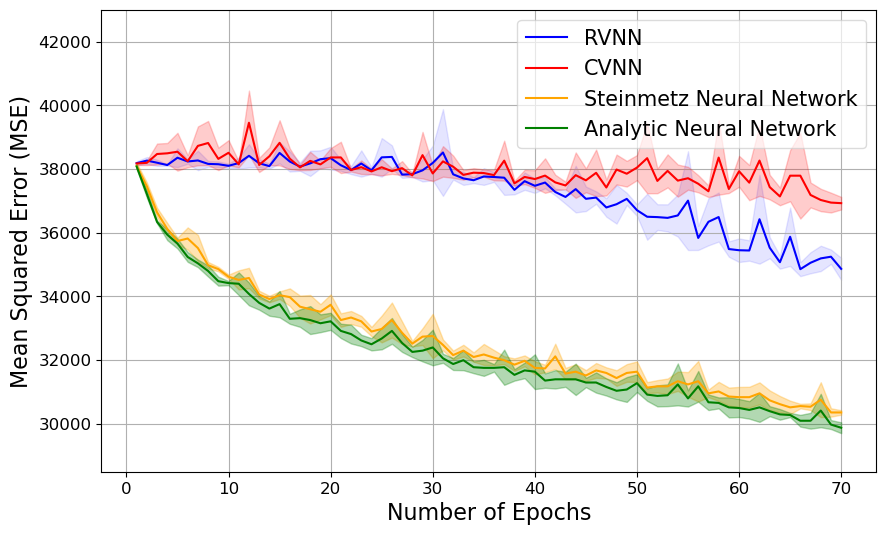

In [47]:
# Step 2: Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=0)
    std_error = np.std(data, axis=0) / np.sqrt(data.shape[0])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci

X = test_error_rvnn[:,:]; Y = test_error_cvnn[:,:]
Z = test_error_steinmetz[:,:]; A = test_error_analytic[:,:];

# Compute mean and CI for accuracies
mean_X, ci_X = compute_mean_and_CI(test_error_rvnn)
mean_Y, ci_Y = compute_mean_and_CI(test_error_cvnn)
mean_Z, ci_Z = compute_mean_and_CI(test_error_steinmetz)
mean_A, ci_A = compute_mean_and_CI(test_error_analytic)

print(f'Mean RVNN:       {mean_X[len(mean_X)-1].round(4)}, STDEV RVNN:      {ci_X[len(ci_X)-1].round(4)}')
print(f'Mean CVNN:       {mean_Y[len(mean_Y)-1].round(4)}, STDEV CVNN:      {ci_Y[len(ci_Y)-1].round(4)}')
print(f'Mean Steinmetz:       {mean_Z[len(mean_Z)-1].round(4)}, STDEV RVNN:      {ci_Z[len(ci_Z)-1].round(4)}')
print(f'Mean Analytic:       {mean_A[len(mean_A)-1].round(4)}, STDEV CVNN:      {ci_A[len(ci_A)-1].round(4)}')

# Step 3: Plot the results
epochs_all = list(range(1, X.shape[1] + 1))
plt.figure(figsize=(10, 6))

# Plotting for X
plt.fill_between(epochs_all, mean_X - ci_X, mean_X + ci_X, color='blue', alpha=0.1, zorder=0)
plt.plot(epochs_all, mean_X, 'b-', label="RVNN", zorder=20)

# Plotting for Y
plt.fill_between(epochs_all, mean_Y - ci_Y, mean_Y + ci_Y, color='red', alpha=0.2, zorder=5)
plt.plot(epochs_all, mean_Y, 'r-', label="CVNN", zorder=25)

# Plotting for Z
plt.fill_between(epochs_all, mean_Z - ci_Z, mean_Z + ci_Z, color='orange', alpha=0.3, zorder=10)
plt.plot(epochs_all, mean_Z, '-', color='orange', label="Steinmetz Neural Network", zorder=30)

# Plotting for A
plt.fill_between(epochs_all, mean_A - ci_A, mean_A + ci_A, color='green', alpha=0.3, zorder=15)
plt.plot(epochs_all, mean_A, 'g-', label="Analytic Neural Network", zorder=35)

# Additional plot settings
plt.xlabel("Number of Epochs", fontsize=16)
plt.ylabel("Mean Squared Error (MSE)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('linear')
plt.ylim((28500, 43000))
plt.legend(prop={'size': 15}, framealpha=0.7, loc='upper right').set_zorder(50)
plt.grid(True)
plt.savefig('Results/RASPNet_epochs.png', bbox_inches='tight')
plt.show()